# Load dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
EnergySet = pd.read_csv("data/energydata_complete.csv")
energydf = pd.DataFrame(data=EnergySet)

Quick look at what the dataset contains

In [3]:
energydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
date           19735 non-null object
Appliances     19735 non-null int64
lights         19735 non-null int64
T1             19735 non-null float64
RH_1           19735 non-null float64
T2             19735 non-null float64
RH_2           19735 non-null float64
T3             19735 non-null float64
RH_3           19735 non-null float64
T4             19735 non-null float64
RH_4           19735 non-null float64
T5             19735 non-null float64
RH_5           19735 non-null float64
T6             19735 non-null float64
RH_6           19735 non-null float64
T7             19735 non-null float64
RH_7           19735 non-null float64
T8             19735 non-null float64
RH_8           19735 non-null float64
T9             19735 non-null float64
RH_9           19735 non-null float64
T_out          19735 non-null float64
Press_mm_hg    19735 non-null float64
RH_out         19735 n

In [5]:
energydf.corr()["Appliances"].map(abs).sort_values(ascending=False)

Appliances     1.000000
lights         0.197278
RH_out         0.152282
T2             0.120073
T6             0.117638
T_out          0.099155
RH_8           0.094039
Windspeed      0.087122
RH_1           0.086031
T3             0.085060
RH_6           0.083178
RH_2           0.060465
RH_7           0.055642
T1             0.055447
RH_9           0.051462
T4             0.040281
T8             0.039572
RH_3           0.036292
Press_mm_hg    0.034885
T7             0.025801
T5             0.019760
RH_4           0.016965
Tdewpoint      0.015353
rv1            0.011145
rv2            0.011145
T9             0.010010
RH_5           0.006955
Visibility     0.000230
Name: Appliances, dtype: float64

# Split training and test data sets

In [6]:
from sklearn.model_selection import train_test_split

energy_train, energy_test = train_test_split(energydf, test_size=0.2, random_state=42)

# Preprocessing
Cleaning the data and converting any data types

In [7]:
# See if there are incorrect values from mix/max
# eg, negative humidity
pd.set_option("display.max_columns", 30)
energy_train.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000
mean,97.949709,3.808589,21.688684,40.266486,20.345215,40.428811,22.269113,39.248114,20.854106,39.047357,19.598492,50.948632,7.913931,54.637155,20.266936,35.410537,22.029474,42.964343,19.488493,41.570982,7.418384,755.532075,79.822742,4.030780,38.330689,3.781387,25.027694,25.027694
std,103.136328,7.963182,1.609561,3.957219,2.196357,4.067871,2.007629,3.245545,2.051129,4.329110,1.850812,9.001768,6.102256,31.210844,2.116903,5.109426,1.959194,5.219066,2.021992,4.156227,5.327514,7.373040,14.895451,2.436011,11.815744,4.202189,14.504991,14.504991
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,30.166667,-6.030000,1.000000,15.390000,23.230000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.006033,0.006033
25%,50.000000,0.000000,20.775937,37.399167,18.823333,37.900000,20.790000,36.900000,19.533333,35.590000,18.290000,45.433333,3.595000,29.991500,18.700000,31.500000,20.790000,39.090000,18.000000,38.530000,3.633333,750.916667,70.333333,2.000000,29.000000,0.933333,12.510037,12.510037
50%,60.000000,0.000000,21.600000,39.663333,20.000000,40.500000,22.100000,38.560000,20.633333,38.463333,19.390000,49.078222,7.300000,55.296667,20.060000,34.900000,22.100000,42.427857,19.390000,40.933333,6.933333,756.100000,84.000000,3.666667,40.000000,3.433333,24.912220,24.912220
75%,100.000000,0.000000,22.600000,43.060000,21.500000,43.290000,23.290000,41.760000,22.100000,42.193333,20.632083,53.702500,11.263333,83.300833,21.600000,39.016500,23.390000,46.561667,20.600000,44.363333,10.416667,760.937500,91.666667,5.500000,40.000000,6.600000,37.665543,37.665543
max,1080.000000,70.000000,26.260000,57.423333,29.856667,54.766667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,25.963333,51.327778,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.400000,49.996530,49.996530


In [11]:
energy_train["date"]

2133     2016-01-26 12:30:00
19730    2016-05-27 17:20:00
3288     2016-02-03 13:00:00
7730     2016-03-05 09:20:00
8852     2016-03-13 04:20:00
425      2016-01-14 15:50:00
10277    2016-03-23 01:50:00
15028    2016-04-25 01:40:00
16841    2016-05-07 15:50:00
1890     2016-01-24 20:00:00
14374    2016-04-20 12:40:00
8530     2016-03-10 22:40:00
1282     2016-01-20 14:40:00
18697    2016-05-20 13:10:00
13478    2016-04-14 07:20:00
8542     2016-03-11 00:40:00
14547    2016-04-21 17:30:00
10205    2016-03-22 13:50:00
2714     2016-01-30 13:20:00
13326    2016-04-13 06:00:00
14957    2016-04-24 13:50:00
18874    2016-05-21 18:40:00
17068    2016-05-09 05:40:00
14736    2016-04-23 01:00:00
15952    2016-05-01 11:40:00
2760     2016-01-30 21:00:00
18380    2016-05-18 08:20:00
8299     2016-03-09 08:10:00
7834     2016-03-06 02:40:00
16007    2016-05-01 20:50:00
                ...         
17912    2016-05-15 02:20:00
1267     2016-01-20 12:10:00
1899     2016-01-24 21:30:00
3005     2016-

## Clean data
Clean data for invalid values like negative humidity or unrealistic temperatures

In [ ]:
def clean_data(min_value, max_value, columns, data):
    clean_data = data.copy()
    for col in columns:
        # Only keep rows where column date is within the min and max values
        clean_data = clean_data[ (clean_data[col] <= max_value)
                               & (clean_data[col] >= min_value)]
    return clean_data

Example of using the `clean_data` method, where we want the column `T1` to have values between 20 and 50

In [ ]:
clean_data(20,50,["T1"],energy_train)

### Turn cleaning step into pipeline step

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataCleaner(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self # No fitting for cleaning step
        
    def transform(self, X):
        # Temperature columns
        Tcols= ["T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "T_out", "Tdewpoint"]
        
        # Humidity columns
        RHcols = ["RH_1", "RH_2", "RH_3", "RH_4", "RH_5", "RH_6", "RH_7", "RH_8", "RH_9", "RH_out"]
        
        X = self.clean_data(-50,50,Tcols,X) # Clean temperatures
        X = self.clean_data(0,100,RHcols,X) # Clean humidity
        
        return X
    

    def clean_data(self, min_value, max_value, columns, data):
        clean_data = data.copy()
        for col in columns:
            clean_data = clean_data[ (clean_data[col] <= max_value)
                                   & (clean_data[col] >= min_value)]
        return clean_data

## Convert date timestamp to numeric values

In [25]:
from datetime import datetime

def parse_timestamp(timestamp):
    return datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S")

A testing dataframe is populated here to show examples of each conversion

In [46]:
time_test = energy_train.copy()
time_test = time_test.loc[:, "date":"Appliances"]

### Numeric
Turn datetime into basic numeric forms, for example monday=0, tuesday=1...

In [49]:
def get_numeric_time(timestamp):
    dt = parse_timestamp(timestamp)
    hour = dt.hour
    day = dt.weekday()
    
    return hour,day

Example numeric time conversion

In [50]:
time_test[["hour_num", "day_num"]] = energy_train["date"].map(get_numeric_time).apply(pd.Series)

In [51]:
time_test[["date","hour_num", "day_num"]].head(5)

,date,hour_num,day_num
2133,2016-01-26 12:30:00,12,1
19730,2016-05-27 17:20:00,17,4
3288,2016-02-03 13:00:00,13,2
7730,2016-03-05 09:20:00,9,5
8852,2016-03-13 04:20:00,4,6


### Cyclic
Due to the nature of time being cyclical, we want to keep this characteristic for our learning model. A way to do this is using sine and cosine transformations.
https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

In [52]:
def get_cyclic_time(timestamp):
    dt = parse_timestamp(timestamp)
    
    hour_sin = np.sin(2*np.pi*dt.hour/24)
    hour_cos = np.cos(2*np.pi*dt.hour/24)
    day_sin = np.sin(2*np.pi*dt.weekday()/7)
    day_cos = np.cos(2*np.pi*dt.weekday()/7)
    
    return hour_sin, hour_cos, day_sin, day_cos

Example cyclic time conversion

In [53]:
time_test[["hour_sin", "hour_cos", "day_sin", "day_cos"]] = energy_train["date"].map(get_cyclic_time).apply(pd.Series)

In [54]:
time_test[["date", "hour_sin", "hour_cos", "day_sin", "day_cos"]].head(5)

,date,hour_sin,hour_cos,day_sin,day_cos
2133,2016-01-26 12:30:00,1.224647e-16,-1.000000,0.781831,0.623490
19730,2016-05-27 17:20:00,-9.659258e-01,-0.258819,-0.433884,-0.900969
3288,2016-02-03 13:00:00,-2.588190e-01,-0.965926,0.974928,-0.222521
7730,2016-03-05 09:20:00,7.071068e-01,-0.707107,-0.974928,-0.222521
8852,2016-03-13 04:20:00,8.660254e-01,0.500000,-0.781831,0.623490


### Seconds from midnight
A feature used by the paper is to extract the timestamp as the number of seconds from midnight (NSM) instead of using the actual hours of the day

In [55]:
def get_nsm(timestamp):
    dt = parse_timestamp(timestamp)
    midnight = dt.replace(hour=0, minute=0, second=0, microsecond=0)
    
    seconds = (dt - midnight).seconds
    
    return seconds
    
def get_cyclic_nsm(timestamp):
    seconds = get_nsm(timestamp)
    seconds_sin = np.sin(2*np.pi*seconds/(24*60*60))
    seconds_cos = np.cos(2*np.pi*seconds/(24*60*60))
    
    return seconds_sin, seconds_cos

Example NSM conversion

In [56]:
time_test[["NSM"]] = energy_train["date"].map(get_nsm).apply(pd.Series)
time_test[["NSM_sin", "NSM_cos"]] = energy_train["date"].map(get_cyclic_nsm).apply(pd.Series)

In [57]:
time_test[["NSM", "NSM_sin", "NSM_cos"]].head(5)

,NSM,NSM_sin,NSM_cos
2133,45000,-0.130526,-0.991445
19730,62400,-0.984808,-0.173648
3288,46800,-0.258819,-0.965926
7730,33600,0.642788,-0.766044
8852,15600,0.906308,0.422618


### Categorical day of the week
As NSM does not convey any information about the day of the week, we can also convert the date into categorical values for each day of the week

In [58]:
def get_categorical_day(timestamp):
    dt = parse_timestamp(timestamp)
    day_num = dt.weekday()

    # Categories in order: Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday
    categories = [0,0,0,0,0,0,0]
    categories[day_num] = 1
    
    return tuple(categories)

In [59]:
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
time_test[days_of_week] = energy_train["date"].map(get_categorical_day).apply(pd.Series)

In [60]:
time_test[["date"] + days_of_week].head(5)

,date,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
2133,2016-01-26 12:30:00,0,1,0,0,0,0,0
19730,2016-05-27 17:20:00,0,0,0,0,1,0,0
3288,2016-02-03 13:00:00,0,0,1,0,0,0,0
7730,2016-03-05 09:20:00,0,0,0,0,0,1,0
8852,2016-03-13 04:20:00,0,0,0,0,0,0,1


Comparison of different timestamp metrics.

In [61]:
time_correlation = time_test.corr()
time_correlation["Appliances"].map(abs).sort_values(ascending=False)

Appliances    1.000000
NSM_sin       0.257612
hour_cos      0.235795
hour_sin      0.232684
NSM           0.214894
hour_num      0.214376
NSM_cos       0.208421
day_sin       0.057391
Tuesday       0.044684
Monday        0.043015
Friday        0.035578
Saturday      0.034275
Wednesday     0.028898
Thursday      0.027322
day_num       0.011186
Sunday        0.010539
day_cos       0.000270
Name: Appliances, dtype: float64

### Turn time conversion into a step in the pipeline

In [ ]:
from enum import Enum

# Enum for different kinds of time conversion
class TimeConversion(Enum):
    NUMERIC = 1
    CYCLIC = 2
    NSM = 3
    NSM_CYCLIC = 4
    CATEGORICAL = 5


# This transformer takes the DataFrame and converts the date timestamp
# The date column is then dropped
class DatetimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, choice=TimeConversion.CYCLIC):
        self.choice = choice
        
    def fit(self, X, y=None):
        return self # No fitting in transformer
    
    def transform(self, X):
        if self.choice == TimeConversion.NUMERIC:
            numeric_columns = ["hour_num", "day_num"]
            
            X[numeric_columns] = self.mapTransformation(X, get_numeric_time)
            return self.dropDate(X)
            
        elif self.choice == TimeConversion.CYCLIC:
            cyclic_columns = ["hour_sin", "hour_cos", "day_sin", "day_cos"]
            
            X[cyclic_columns] = self.mapTransformation(X, get_cyclic_time)
            return self.dropDate(X)
        
        elif self.choice == TimeConversion.NSM:
            X[["NSM"]] = self.mapTransformation(X, get_nsm)
            return self.dropDate(X)
        
        elif self.choice == TimeConversion.NSM_CYCLIC:
            nsm_columns = ["NSM_sin", "NSM_cos"]
            
            X[nsm_columns] = self.mapTransformation(X, get_cyclic_nsm)
            return self.dropDate(X)
        
        elif self.choice == TimeConversion.CATEGORICAL:
            categorical_columns = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
            
            X[categorical_columns] = self.mapTransformation(X, get_categorical_day)
            return self.dropDate(X)
        
        else:
            # No transformation
            return pd.DataFrame(X)
        
    def mapTransformation(self, X, mapper):
        return X["date"].map(mapper).apply(pd.Series)
    
    def dropDate(self, X):
        return X.drop("date", axis=1)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

test_pipe = Pipeline([
    ("clean_data", DataCleaner()),
    ("date_transform", DatetimeTransformer(DT.CYCLIC))
])

### Plot histograms for all columns

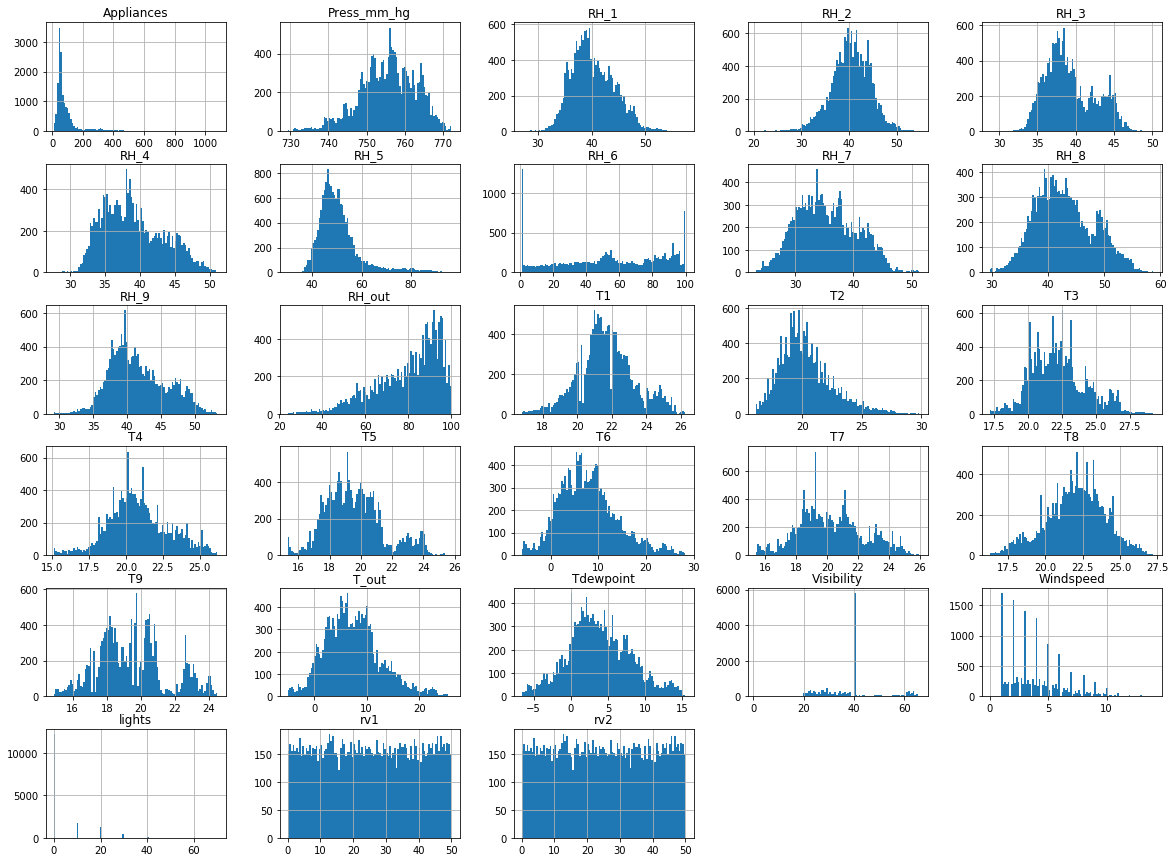

In [62]:
hists = energy_train.hist(bins=100,figsize=(20,15))

## Feature scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaling = Pipeline([
    ("scaler", StandardScaler())
])



In [ ]:
scaler = MinMaxScaler()

In [ ]:
new_c = energy.drop("date", axis=1)

In [ ]:
scaled = scaling.fit_transform(energy.drop("date", axis=1))

In [ ]:
scaled = pd.DataFrame(scaled, index=new_c.index, columns=new_c.columns)

In [ ]:
scaled["Appliances"].unique()

In [ ]:
cm = energy.corr()
cm["Appliances"].map(abs).sort_values(ascending=False)

### Data selection

In [ ]:
energy

In [ ]:
energy.drop(columns=["date"])

In [ ]:
data_pipeline = Pipeline([
    ("normalise", StandardScaler())
])


In [ ]:
normalised = data_pipeline.fit_transform(energy.drop(columns=["date"]))

In [ ]:
normalised

### Check correlations

In [ ]:
cm = energy.corr()
cm["Appliances"].map(abs).sort_values(ascending=False)

## Model selection and training

In [ ]:
from sklearn.linear_model import LinearRegression

### Misc pipeline stages

The `DFNPConverter` converts between a DataFrame and numpy array.

In [ ]:
class DFNPConverter(BaseEstimator, TransformerMixin):
    def __init__(self, toDF=True, DF_index=None, DF_columns=None):
        self.toDF = toDF
        
        # If converting back to DF, need index and columns of original DataFrame
        self.DF_index = DF_index
        self.DF_columns = DF_columns
        
    def fit(self, X, y=None):
        return self # No fitting for df/np conversion
    
    def transform(self, X):
        if self.toDF:
            return pd.DataFrame(X, index=self.DF_index, columns=self.DF_columns)
        
        else:
            return X.values

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

preprocessing_pipeline = Pipeline([
    ("cleaning", DataCleaner()),
    ("time_conversion", DatetimeTransformer(TimeConversion.CYCLIC)),
        ("poly", PolynomialFeatures(degree=2)),
    ("feature_scaling", StandardScaler())
    #("to_np_array", DFNPConverter(toDF=True, DF_index=energy_train.index, DF_columns=energy_train.columns))
])

linreg_pipeline = Pipeline([
    ("preprocessing", preprocessing_pipeline),
    ("linear_regression", LinearRegression())
])

polyreg2_pipeline = Pipeline([
    ("preprocessing", preprocessing_pipeline),
    ("poly", PolynomialFeatures(degree=2)),
    ("linear", LinearRegression())
])

polyreg3_pipeline = Pipeline([
    ("preprocessing", preprocessing_pipeline),

    ("linear", LinearRegression())
])

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

input = energy_train.drop(["Appliances", "rv1", "rv2", "Visibility"], axis=1)
output = energy_train["Appliances"]

In [ ]:
class Trainer():
    def __init__(self, model, input, output, kfold=5):
        self.model = model
        self.input = input
        self.output = output
        self.kfold = kfold
        
    def 
    

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

In [ ]:
kfold = KFold(n_splits=3)

In [ ]:
scoring_methods={"nmse": "neg_mean_squared_error", 
                 "r2": "r2", 
                 "nmae": "neg_mean_absolute_error"}

In [ ]:
lin_res = cross_val_predict(linreg_pipeline, input, output, cv=5)
poly2_res = cross_val_predict(polyreg2_pipeline, input, output, cv=5)
#poly3_res = cross_validate(polyreg3_pipeline, input, output, cv=kfold, scoring=scoring_methods)

In [ ]:
lin_res

In [ ]:
plt.scatter(poly2_res, output)

In [ ]:
lin_res

In [ ]:
poly2_res

In [ ]:
from sklearn.linear_model import Ridge

ridge_pipeline = Pipeline([
    ("preprocessing", preprocessing_pipeline),
    ("poly", PolynomialFeatures(degree=2)),
    ("ridge", Ridge(alpha=0.9))
])

In [ ]:
from sklearn.linear_model import Lasso

lasso_pipeline = Pipeline([
    ("preprocessing", preprocessing_pipeline),
    ("poly", PolynomialFeatures(degree=2)),
    ("lasso", Lasso(alpha=0.3))
])

In [ ]:
ridge_res = cross_val_predict(ridge_pipeline, input, output.map(np.log), cv=5)
lasso_res = cross_val_predict(lasso_pipeline, input, output.map(np.log), cv=5)

In [ ]:
l = list(map(np.exp, ridge_res))

In [ ]:
plt.scatter(l, output, alpha=0.1)
plt.xlabel("Predicted value")
plt.ylabel("True value")

In [ ]:
ls = list(map(np.exp, lasso_res))

In [ ]:
plt.scatter(l, output, alpha=0.1)
plt.xlabel("Predicted value")
plt.ylabel("True value")

In [ ]:
np.sqrt(mean_squared_error(output, lin_res))

In [ ]:
np.sqrt(mean_squared_error(output, poly2_res))

In [ ]:
np.sqrt(mean_squared_error(output, l))

In [ ]:
np.sqrt(mean_squared_error(output, ls))

In [ ]:
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import (Exchangeable, Independence, Autoregressive)
from statsmodels.genmod.families import Poisson

In [ ]:
lr = LinearRegression()
lr.fit(p, energy_train["Appliances"])

In [ ]:
linreg_predictions = lr.predict(p)
linreg_mse = mean_squared_error(energy_train["Appliances"], linreg_predictions)
linreg_rmse = np.sqrt(linreg_mse)

In [ ]:
linreg_mse

In [ ]:
linreg_rmse